# Training without b-boxes.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


In [0]:
cd /content/gdrive/'My Drive'/KURSACH

In [0]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import sys
import tarfile
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
#from IPython.display import display, Image, HTML
import h5py

%matplotlib inline

# **Создание класса датасета**

In [0]:
class TrainSVHN(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.samples = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.samples.iloc[idx, 0])
        image = io.imread(img_name)
        #image = Image.open(img_name).convert('RGB')
        boxes = self.samples.iloc[idx, 1:5].values#as_matrix()
        length = self.samples.iloc[idx, 6]
        labels = self.samples.iloc[idx, 5]
        labels=labels.replace("[","").replace("]","")
        labels=labels.split(",")
        labels = np.asarray(labels)
        labels=labels.astype('float')
        labels = np.array(labels)
        labels = labels.astype(int)
        labels[labels==10] = 0
        digits = np.full(5, 10, dtype=int)
        if labels.shape[0] > 5:
          return self.__getitem__(idx+1)
        for i in range(labels.shape[0]):
          digits[i] = labels[i]
          
          
        labels = ''.join([str(i) for i in labels])
        labels = int(labels)
        labels = np.full(1,labels,dtype=int)
        boxes = boxes.astype('float').reshape(-1, 4)
        length = int(length)
        length = np.full(1,length,dtype=int)
        sample = {'image': image, 'boxes': boxes, 'length': length, 'labels': labels, 'digits':digits}

        if self.transform:
            sample = self.transform(sample)

        return sample
       
  
import matplotlib.patches as patches
def display_bbox(image, boxes, length, labels, digits):
    fig, ax = plt.subplots(1)
    #plt.imshow(np.squeeze(image))
    plt.imshow(image)
    print('Length:',length)
    print('True label:',labels)
    print('Digits:',digits)
    rect = patches.Rectangle((boxes[0][0],boxes[0][3]),boxes[0][2]-boxes[0][0],boxes[0][1]-boxes[0][3],edgecolor='g',facecolor='none',lw=3) 
    ax.add_patch(rect)
    ax.grid(False)
    plt.show()
      

In [0]:
transformed_dataset_train = TrainSVHN(csv_file='data/bounding_boxes_train.csv',
                                    root_dir='data/train/',
                                           transform=transforms.Compose([
                                              Rescale(64),RandomCrop(54),
                                              ToTensor()
                                           ]))

In [0]:
transformed_dataset_train[0]

**Определение transform-функций для обработки изображений**

In [0]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']
        length = sample['length']
        labels = sample['labels']
        digits = sample['digits']
        #w, h = image.size
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
               new_h, new_w = self.output_size, self.output_size
        new_h, new_w = int(new_h), int(new_w)

        image = transform.resize(image, (new_h, new_w), mode='constant',anti_aliasing=True)
        boxes = boxes * [new_w / w, new_h / h, new_w / w, new_h / h]

        return {'image': image, 'boxes': boxes,'length': length,'labels': labels,'digits':digits}
class ToTensor(object):

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']
        length = sample['length']
        labels = sample['labels']
        digits = sample['digits']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'boxes': torch.from_numpy(boxes),'length':  length,'labels': torch.from_numpy(labels),'digits':torch.from_numpy(digits) }

In [0]:
class RandomCrop(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']
        length = sample['length']
        labels = sample['labels']
        digits = sample['digits']
        #w, h = image.size
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        boxes = boxes - [left, top, left, top]

        return {'image': image, 'boxes': boxes,'length': length,'labels': labels,'digits':digits}

In [0]:
transformed_dataset_train = TrainSVHN(csv_file='data/bounding_boxes_train.csv',
                                    root_dir='data/train/',
                                           transform=transforms.Compose([
                                              Rescale(64), RandomCrop(54),
                                              ToTensor() #, transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                           ]))
train_loader = DataLoader(transformed_dataset_train,batch_size=4,
                        shuffle=True, num_workers=4)

In [0]:
sample = transformed_dataset_train[6]
display_bbox(**sample)

In [0]:
for i in range(len(transformed_dataset_train)):
    sample = transformed_dataset_train[i]

    print(i, sample['image'].size(), sample['boxes'].size())

    if i == 3:
        break

0 torch.Size([3, 54, 54]) torch.Size([1, 4])
1 torch.Size([3, 54, 54]) torch.Size([1, 4])
2 torch.Size([3, 54, 54]) torch.Size([1, 4])
3 torch.Size([3, 54, 54]) torch.Size([1, 4])


In [0]:
def show_boxes_batch(sample_batched):
    images_batch, boxes_batch = \
            sample_batched['image'], sample_batched['boxes']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    fig, ax = plt.subplots(1)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    print(im_size)
    for i in range(batch_size):
        rect = patches.Rectangle((boxes_batch[i][0][0].numpy() + i * im_size,boxes_batch[i][0][3].numpy() ),boxes_batch[i][0][2].numpy() - boxes_batch[i][0][0].numpy()+i*batch_size,boxes_batch[i][0][1].numpy() - boxes_batch[i][0][3].numpy(),edgecolor='g',facecolor='none',lw=3) 
        ax.add_patch(rect)
       # plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
          #          landmarks_batch[i, :, 1].numpy(),
          #          s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

54


<Figure size 432x288 with 0 Axes>

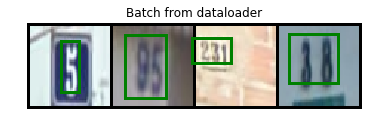

In [0]:
for i_batch, sample_batched in enumerate(train_loader):
    #print(i_batch, sample_batched['image'].size())
    if i_batch == 3:
        plt.figure()
        show_boxes_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [0]:
transformed_dataset_train = TrainSVHN(csv_file='data/bounding_boxes_train.csv',
                                    root_dir='data/train/',
                                           transform=transforms.Compose([
                                              Rescale(64), RandomCrop(54),
                                              ToTensor() #, transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                           ]))
train_loader = DataLoader(transformed_dataset_train,batch_size=4,
                        shuffle=True, num_workers=4)

In [0]:
transformed_dataset_train[0]

# Обучение


In [0]:
device = torch.device("cuda:0")

**Определение модели**

In [0]:
class Model(nn.Module): #картинка 54x54
    def __init__(self):
        super(Model, self).__init__()

        hidden1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=48, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=48),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hidden2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hidden3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hidden4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=160, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=160),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hidden5 = nn.Sequential(
            nn.Conv2d(in_channels=160, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hidden6 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hidden7 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hidden8 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hidden9 = nn.Sequential(
            nn.Linear(192 * 7 * 7, 3072),
            nn.ReLU()
        )
        hidden10 = nn.Sequential(
            nn.Linear(3072, 3072),
            nn.ReLU()
        )

        self._features = nn.Sequential(
            hidden1,
            hidden2,
            hidden3,
            hidden4,
            hidden5,
            hidden6,
            hidden7,
            hidden8
        )
        self._classifier = nn.Sequential(
            hidden9,
            hidden10
        )
        self._digit_length = nn.Sequential(nn.Linear(3072, 7))
        self._digit1 = nn.Sequential(nn.Linear(3072, 11))
        self._digit2 = nn.Sequential(nn.Linear(3072, 11))
        self._digit3 = nn.Sequential(nn.Linear(3072, 11))
        self._digit4 = nn.Sequential(nn.Linear(3072, 11))
        self._digit5 = nn.Sequential(nn.Linear(3072, 11))

    def forward(self, x):
        x = self._features(x)
        x = x.view(x.size(0), 192 * 7 * 7)
        x = self._classifier(x)

        length_logits, digits_logits = self._digit_length(x), [self._digit1(x),
                                                               self._digit2(x),
                                                               self._digit3(x),
                                                               self._digit4(x),
                                                               self._digit5(x)]
        return length_logits, digits_logits

In [0]:
def _loss(length_logits, digits_logits, length_labels, digits_labels):
    length_cross_entropy = torch.nn.functional.cross_entropy(length_logits, length_labels)
    digit1_cross_entropy = torch.nn.functional.cross_entropy(digits_logits[0], digits_labels[:,0])
    digit2_cross_entropy = torch.nn.functional.cross_entropy(digits_logits[1], digits_labels[:,1])
    digit3_cross_entropy = torch.nn.functional.cross_entropy(digits_logits[2], digits_labels[:,2])
    digit4_cross_entropy = torch.nn.functional.cross_entropy(digits_logits[3], digits_labels[:,3])
    digit5_cross_entropy = torch.nn.functional.cross_entropy(digits_logits[4], digits_labels[:,4])
    loss = length_cross_entropy + digit1_cross_entropy + digit2_cross_entropy + digit3_cross_entropy + digit4_cross_entropy + digit5_cross_entropy
    return loss

In [0]:
model = Model() 

In [0]:
model.to(device)

In [0]:
import time
from datetime import datetime
from torch.autograd import Variable

In [0]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)


In [0]:
num_steps_to_show_loss = 1000
num_steps_to_check = 2000
step = 0
best_accuracy = 0.0
duration = 0.0
batch_size=4
learning_rate = 0.1

In [0]:
PATH = 'data/checkpoint_much_epochs.pth'

In [0]:
NPATH = 'data/checkpoint_final.pth'

In [0]:
model = Model()
model.load_state_dict(torch.load(PATH))
model.cuda()

In [0]:
for epoch in range(30):  # loop over the dataset multiple times
  for i, sample_batched in enumerate(train_loader):
    start_time = time.time()
    images = sample_batched['image']
    length_labels = sample_batched['length']
    digits_labels = sample_batched['digits']
    images = images.float()
    length_labels = length_labels.type(torch.LongTensor)
    length_labels.squeeze_()
    #print(length_labels)
    #digits_labels = digits_labels.float()
    #digits_labels = digits_labels.squeeze_()
    #print(digits_labels)
   
    images, length_labels, digits_labels = (Variable(images.cuda()),
                                                    Variable(length_labels.cuda()),
                                                    Variable(digits_labels.cuda()))
    length_logits, digits_logits = model.train()(images)
    loss = _loss(length_logits, digits_logits, length_labels, digits_labels)
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    step += 1
    duration += time.time() - start_time
    if step % num_steps_to_show_loss == 0:
      examples_per_sec = batch_size * num_steps_to_show_loss / duration
      duration = 0.0
      print('=> %s: step %d, loss = %f, learning_rate = %f (%.1f examples/sec)' % (
      datetime.now(), step, loss.data, learning_rate, examples_per_sec))
    
    if step % num_steps_to_check == 0:
      accuracy = evaluator.evaluate(model)
      print('==> accuracy = %f, best accuracy %f' % (accuracy, best_accuracy))
      if accuracy > best_accuracy:
        torch.save(model.state_dict(), NPATH)
        print('=> Model saved to file: %s' % NPATH)
        best_accuracy = accuracy
    

=> 2019-05-08 15:43:01.398075: step 1000, loss = 1.796222, learning_rate = 0.100000 (116.2 examples/sec)
==> accuracy = 0.262550, best accuracy 0.265381
=> 2019-05-08 15:45:48.152780: step 2000, loss = 5.072160, learning_rate = 0.100000 (119.8 examples/sec)
==> accuracy = 0.265152, best accuracy 0.265381
=> 2019-05-08 15:48:35.796369: step 3000, loss = 3.654730, learning_rate = 0.100000 (123.8 examples/sec)
==> accuracy = 0.260866, best accuracy 0.265381
=> 2019-05-08 15:51:22.605631: step 4000, loss = 3.115711, learning_rate = 0.100000 (121.5 examples/sec)
==> accuracy = 0.262244, best accuracy 0.265381
=> 2019-05-08 15:54:10.218381: step 5000, loss = 4.074056, learning_rate = 0.100000 (123.0 examples/sec)
==> accuracy = 0.265305, best accuracy 0.265381
=> 2019-05-08 15:56:55.425364: step 6000, loss = 4.114986, learning_rate = 0.100000 (130.1 examples/sec)
==> accuracy = 0.259489, best accuracy 0.265381
=> 2019-05-08 15:59:39.031504: step 7000, loss = 2.039234, learning_rate = 0.10000

KeyboardInterrupt: ignored

**ТОЧНОСТЬ 26,7%**

In [0]:
PATH = 'data/checkpoint_5epochs.pth'

In [0]:
torch.save(model.state_dict(), PATH)

# Тестирование


In [0]:
transformed_dataset_test = TrainSVHN(csv_file='data/bounding_boxes_test.csv',
                                    root_dir='data/test/',
                                           transform=transforms.Compose([
                                              Rescale(64), RandomCrop(54),
                                              ToTensor() #, transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                           ]))
train_loader = DataLoader(transformed_dataset_test,batch_size=4,
                        shuffle=False, num_workers=4)

In [0]:
transformed_dataset_test[0]

In [0]:
def _infer(path_to_checkpoint_file, path_to_input_image):
    model = Model()
   # model.restore(path_to_checkpoint_file)
    model.load_state_dict(torch.load(path_to_checkpoint_file))
    model.eval()
    model.cuda()

    with torch.no_grad():
        transform = transforms.Compose([
            transforms.Resize([64, 64]),
            transforms.CenterCrop([54, 54]),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

        image = Image.open(path_to_input_image)
        image = image.convert('RGB')
        image = transform(image)
        images = image.unsqueeze(dim=0).cuda()
        #print(model.eval()(images))
        #length_logits, digit1_logits, digit2_logits, digit3_logits, digit4_logits, digit5_logits = model.eval()(images)
        length_logits, digits_logits = model.eval()(images)

        length_prediction = length_logits.max(1)[1]
        #print(digits_logits[1].max(1)[1].item())
        #digits_prediction = digits_logits.max(1)[1]
        digit1_prediction = digits_logits[0].max(1)[1]
        digit2_prediction = digits_logits[1].max(1)[1]
        digit3_prediction = digits_logits[2].max(1)[1]
        digit4_prediction = digits_logits[3].max(1)[1]
        digit5_prediction = digits_logits[4].max(1)[1]

        print('length:', length_prediction.item())
        print('digits:', digit1_prediction.item(), digit2_prediction.item(), digit3_prediction.item(), digit4_prediction.item(), digit5_prediction.item())

In [0]:
PATH = 'data/checkpoint_final.pth'

In [0]:
def imshow(img):
    img = io.imread(img)
    plt.imshow(img)
    plt.show()

length: 2
digits: 3 1 10 10 10


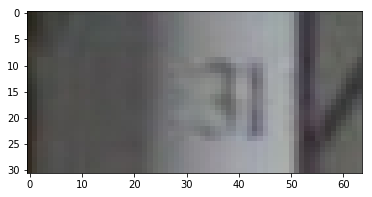

In [0]:
IMAGE = 'data/test/223.png'
_infer(PATH,IMAGE)
imshow(IMAGE)

In [0]:
class Evaluator(object):
    def __init__(self):
        transform = transforms.Compose([
            transforms.CenterCrop([54, 54]),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        transformed_dataset_test = TrainSVHN(csv_file='data/bounding_boxes_test.csv',
                                    root_dir='data/test/',
                                           transform=transforms.Compose([
                                              Rescale(64), RandomCrop(54),
                                              ToTensor() #, transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                           ]))
        self._loader = torch.utils.data.DataLoader(transformed_dataset_test, batch_size=4, shuffle=False)

    def evaluate(self, model):
        num_correct = 0
        needs_include_length = False

        with torch.no_grad():
            for i,  sample_batched in enumerate(self._loader):
                images = sample_batched['image']
                length_labels = sample_batched['length']
                digits_labels = sample_batched['digits']
                #print(digits_labels)
                images = images.float()
                length_labels = length_labels.type(torch.LongTensor)
                length_labels.squeeze_()
                images, length_labels, digits_labels = images.cuda(), length_labels.cuda(),  digits_labels.cuda()
                length_logits, digits_logits = model.eval()(images)

                length_prediction = length_logits.max(1)[1]
                digit1_prediction = digits_logits[0].max(1)[1]
                digit2_prediction = digits_logits[1].max(1)[1]
                digit3_prediction = digits_logits[2].max(1)[1]
                digit4_prediction = digits_logits[3].max(1)[1]
                digit5_prediction = digits_logits[4].max(1)[1]

                
                num_correct += (length_prediction.eq(length_labels) &
                                    digit1_prediction.eq(digits_labels[:,0]) &
                                    digit2_prediction.eq(digits_labels[:,1]) &
                                    digit3_prediction.eq(digits_labels[:,2]) &
                                    digit4_prediction.eq(digits_labels[:,3]) &
                                    digit5_prediction.eq(digits_labels[:,4])).cuda().sum()
        accuracy = num_correct.item() / len(self._loader.dataset)
        return accuracy

In [0]:
evaluator = Evaluator()

In [0]:
PATH = 'data/checkpoint_5epochs.pth'
model = Model()
model.load_state_dict(torch.load(PATH))
model.eval()
model.cuda()
acc = evaluator.evaluate(model)